In [29]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, basinhopping
from itertools import product
from numpy.linalg import cholesky
from tqdm import tqdm
import plotly.graph_objects as go
import funciones_optim
from importlib import reload
reload(funciones_optim)
from mystuff import bdh

from funciones_optim import port_ret,sumauno,var,r_gen,min_vol

#arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [3]:
def normi(x,r):
    m = x.rolling(r,min_periods=1).mean()
    s = x.rolling(r,min_periods=1).std()
    z = x.subtract(m).div(s)
    return z

def momm(x,mas,mal):
    z = x.rolling(mas,min_periods=1).sum()
    s = z.rolling(mal).std()

    return z.div(s)

In [4]:
refs = pd.read_csv('tickers.csv',index_col='ticker')
ticks = refs.label.to_dict()
data = bdh(ticks.keys(),'px_last',(20101231,20231026))
data.columns = pd.MultiIndex.from_tuples([(refs.loc[c,'label'],refs.loc[c,'type']) for c in data.columns],names=('label','typ'))
data.index = pd.to_datetime(data.index)
data = data.resample('W-Wed').last().ffill().dropna(axis=0)


<Axes: xlabel='date'>

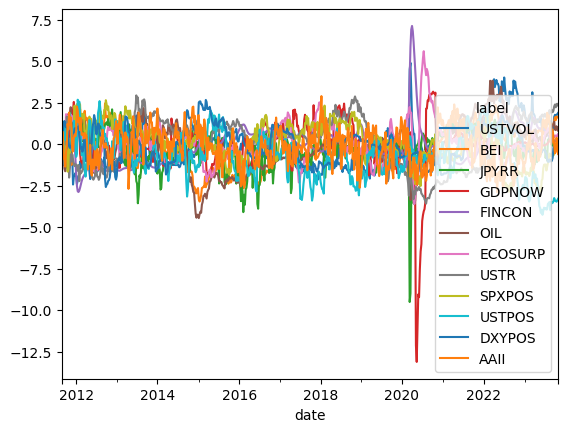

In [5]:
x_ = data.loc[:,[c[1] in ['MACRO','SENTIMENT','POSITIONING','MARKETIMPLIED'] for c in data.columns]].droplevel(level=1,axis=1)
x_['AAII'] = x_.BULL.subtract(x_.BEAR)
x_.drop(['BULL','BEAR'],axis=1,inplace=True)
x_ = x_.apply(normi,axis=0,args=[260])
x_.plot()

In [6]:
rt_ = data.xs('ASSETCLASS',level='typ',axis=1).drop(['USCASH','COCASH'],axis=1)
rt = rt_.pct_change()
rt.USTTEN = rt_.USTTEN.diff()
rt = rt.apply(momm,args=[4,12],axis=0)
rt_.head()

label,USTTEN,USDCOP,SPX,EEM,XAU
date,,,,,
2011-08-31,2.2234,1778.00,1218.89,42.75,1825.55
2011-09-07,2.0429,1790.00,1198.62,42.35,1817.71
2011-09-14,1.9837,1826.50,1188.68,39.88,1819.80
2011-09-21,1.8576,1874.00,1166.76,37.59,1782.30
2011-09-28,1.9797,1918.75,1151.06,36.45,1609.16


USTTEN
1.3732531149729896


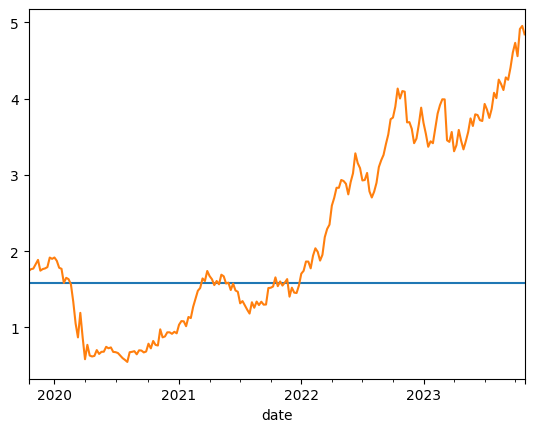

USDCOP
349.1308376139333


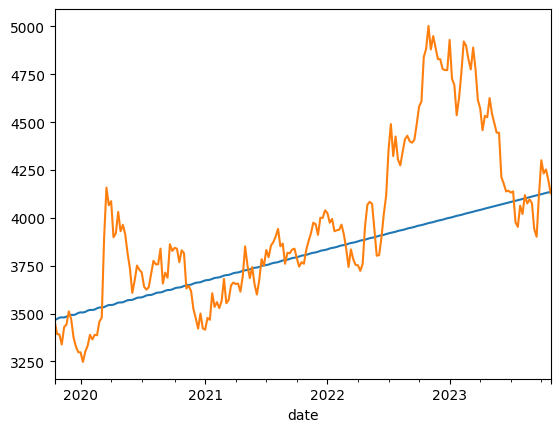

SPX
654.9934033607084


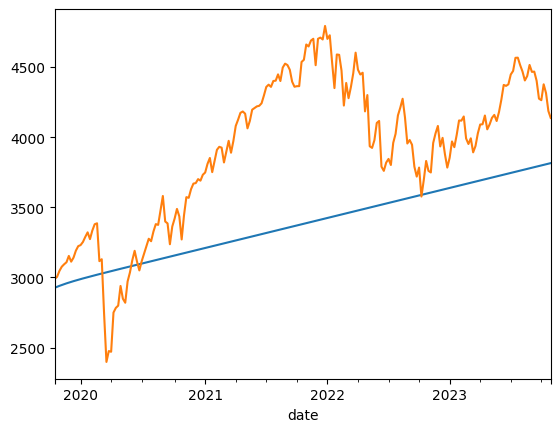

EEM
7.127959795695864


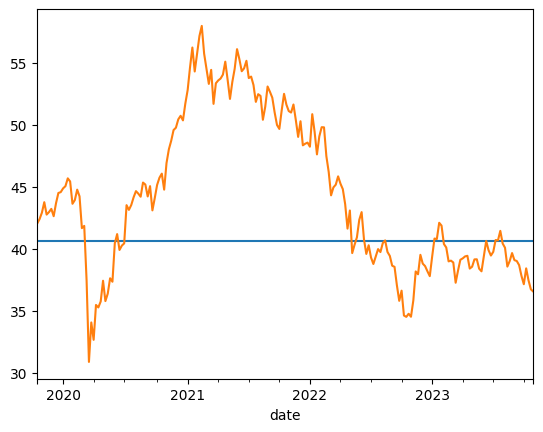

XAU
325.2937842964215


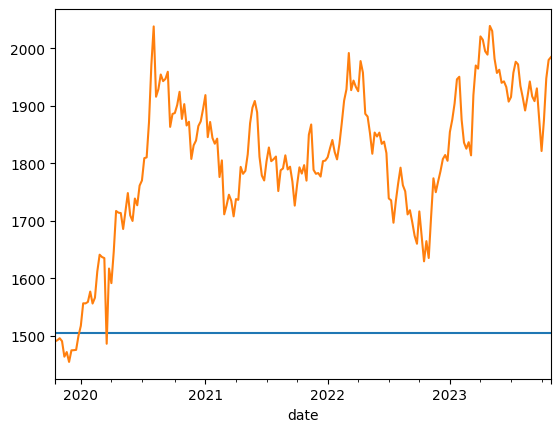

In [40]:
_, ti = TimeSeriesSplit(n_splits=2).split(rt_)
x_train =rt_.iloc[ti[0],:]
x_test = rt_.iloc[ti[1],:]
for c in x_train.columns[:]:
    modl = auto_arima(x_train[c])
    preds = modl.predict(n_periods=len(x_test[c]))
    rmse = np.sqrt(mean_squared_error(x_test[c],preds))
    print(c)
    print(rmse)
    preds.plot()
    x_test[c].plot()
    plt.show()

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [2]:
data = pd.read_csv('series_tiempo.csv',index_col='FECHA')
data.index= pd.to_datetime(data.index,format='%d/%m/%Y')
data.sort_index(inplace=True)
data = data.dropna(axis=0).drop(['CASH'],axis=1)

vol = data.mul(np.sqrt(12)).std()
cor = data.corr()
cov = cor*np.outer(vol,vol)
ret = pd.Series({k:v for k,v in zip(vol.index,[8.8,9,13])})

In [13]:
perfiles = 10  #Perfiles
num_simu = 100  #numero de simulaciones
w = np.array([ 1/len(vol) for i in range(len(vol))])
bounds = [(0,1) for i in range(len(vol))]
minv = min_vol(bounds,cov,w)
maxv = np.max(vol)
target_vol = np.linspace(minv,maxv,num=perfiles)
R = r_gen(num_simu,ret,cor,vol)

opt_ports = {}
for tv in tqdm(target_vol):
    ws_ =[]
    for ri in R:
        constraints = [{'type':'eq','fun':var,'args':(cov,tv)},{'type':'eq','fun':sumauno}]
        result = minimize(port_ret,w,args=(ri),bounds=bounds,constraints=constraints)
        if result.success:
            ws_.append(result.x)
        
    opt_ports[np.round(tv*100,2)] = pd.Series(ws_).mean(axis=0).round(4)
df = pd.DataFrame(opt_ports,index=ret.index).transpose()
df['Return'] = df.apply(port_ret,args=[ret],axis=1).mul(-1).round(3)
df.index.name = 'Volatility'

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


In [16]:
traces=[]
traces.append(go.Scatter(x=df.index,y=df.Return,mode='lines+markers',line={'width':1,'color':'black'},marker={'size':5,'color':'blue'}))
layout = go.Layout(title={'text':'Frontera Eficiente','font':{'size':15}},width=500,height=400,
                   margin={'t':50,'l':20,'r':20,'b':20},template='simple_white',
                   xaxis={'title':{'text':'xVolatility','font':{'size':12}}},
                   yaxis={'title':{'text':'xReturn','font':{'size':12}}})
fig = go.Figure(traces,layout)
fig.show()

